## Model Reduction of the Nonlinear Heat Conduction Problem without hyper-reduction

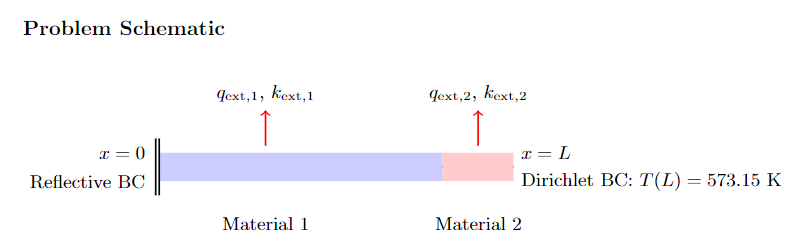

#### Directories

In [1]:
import os
notebook_dir = os.getcwd()
pyhyperrom_dir = '../../../../'
os.chdir(pyhyperrom_dir)
working_dir = os.getcwd()
print(working_dir)

d:\OneDrive - Texas A&M University\Academic\TAMU_MATERIALS\POSTDOC\HYPERREDUCTION\SUPARNO\HYPERREDUCTION__TAMIDS\pyHyperRom


In [2]:
folder = "nonlinear"

#### Standard Imports

In [3]:
# Standard Libraries
import time
import dill as pickle

# Third-Party Libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from cycler import cycler
import ptitprince as pt
import sci_mplstyle_package

# Basic and Utility Imports from Local Modules
from src.codes.basic import *
from src.codes.utils.fem_utils_HC import *
from src.codes.utils.rom_utils import *

# Problem Classes for Heat Conduction
from src.codes.prob_classes.heat_conduction.base_class_heat_conduction import ROM_simulation

# Reduced Order Modeling (ROM) Classes
import src.codes.reductor.rom_class_ms as rom_class

Duplicate key in file 'c:\\Users\\suparnob\\AppData\\Local\\anaconda3\\Lib\\site-packages\\sci_mplstyle_package\\style_files\\publication.mplstyle', line 64 ('axes.axisbelow : True')


#### Plot Properties

In [4]:
# Font properties
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

# # Use LaTeX for math formatting
plt.rcParams['text.usetex'] = False
plt.rcParams['font.serif'] = ['cmr10', 'Computer Modern Serif', 'DejaVu Serif']
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['mathtext.fontset'] = 'cm'

# # Axes properties
plt.rcParams['axes.facecolor'] = '#eaeaf2' #[0.95, 0.95, 0.95]

clr = ['#1f77b4', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
    '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5']
plt.rcParams['axes.prop_cycle']   = cycler('color', clr)


# Legend properties
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.fancybox'] = True
plt.rcParams['legend.framealpha'] = 0.85

#### Generate parameters for parametric study

In [5]:
q_param = (-1000, 1000) # For F
k_param = (-4, 4) # For K
param_ranges = [k_param, q_param]
method = 'sobol'

In [6]:
p = 4
N_snap=2**p
print(N_snap)

16


### Generate Training datasets

In [7]:
import numpy as np
from examples.heat_conduction.OneD_heat_conduction.FEM_1D_data_gen_paper import data_gen

In [ ]:
# filename_dataC = f'data/DataClass_{folder}_{N_snap}_{method}.dill'

filename_dataC = f'DataClass_nonlinear_Final_new_{N_snap}_{method}.dill' # this name was used for the hyperreduction notebooks as well.
if_longpath = r"\\?\\"
full_path = os.path.normpath(if_longpath + notebook_dir+'/'+filename_dataC)


if os.path.exists(full_path):

    generate = False

    with open(full_path, 'rb') as f:
        Data_cls = pickle.load(f)
    

else:

    generate = True
    params_train = generate_sobol(len(param_ranges), N_snap, param_ranges)
    params_test = generate_sobol(len(param_ranges), N_snap, param_ranges)

    params = np.append(params_train,params_test,axis=0)

    train_mask = np.ones(len(params),dtype=bool)
    train_mask[len(params_train):] = False
    # train_mask = bool(train_mask)


    test_mask = np.zeros(len(params),dtype=bool)
    test_mask[len(params_test):] = True

    print(params)


In [ ]:
if(generate):

    tic = time.perf_counter()

    ########### IF YOU SELECT NONLINEAR, UNCOMMENT THE NONLINEAR MATERIAL PROPERTIES IN "FEM_1D_SYSTEM_PROPERTIES.PY" ###############
    
    Data_cls = data_gen(params, full_path, train_mask=train_mask,test_mask=test_mask,ecm=True)

    toc = time.perf_counter()
    fom_time = toc-tic
    print(f"{fom_time=}")

In [ ]:
# load required variables from data
FOS = Data_cls.FOS
d = FOS.data
mask = d.mask

# Convert parameter list to a NumPy array (representing system parameters)
param_list = np.asarray(Data_cls.param_list)

# Load nonlinear solutions from the full-order system
NLS = np.asarray(Data_cls.NL_solutions)

# Split data into training and testing using predefined masks
train_mask, test_mask = Data_cls.train_mask, Data_cls.test_mask  

# Apply Dirichlet mask to filter nonlinear solutions for training and testing
NLS_train = NLS[train_mask][:, d.mask]  # Training set with Dirichlet conditions applied
NLS_test = NLS[test_mask][:, d.mask]  # Testing set with Dirichlet conditions applied

# Get the number of snapshots (time instances or parameter samples)
N_snap, _ = np.shape(NLS)
print(N_snap)  # Print the number of snapshots available

32


In [11]:
os.chdir(working_dir)

### Mean Subtraction

In [12]:
NLS_train_mean = np.mean(NLS_train,axis = 0)
NLS_train_ms = NLS_train - NLS_train_mean

### Plot snapshots

#### Distribution of the training parameters

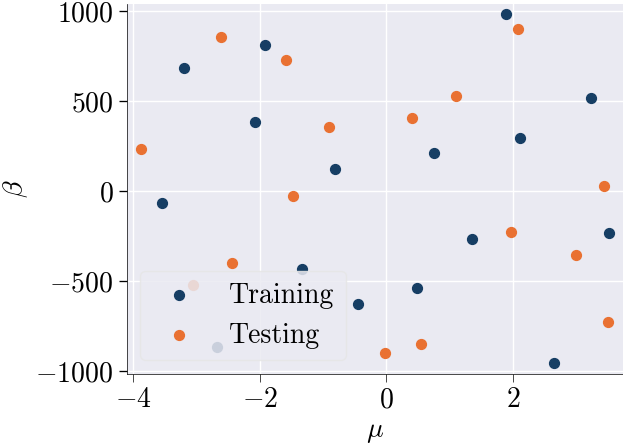

In [13]:
plt.scatter(param_list[:16][:,0],param_list[:16][:,1],s=50,c='#163e64',label="Training")
plt.scatter(param_list[16:][:,0],param_list[16:][:,1],s=50,c='#e97132',label="Testing")
plt.xlabel("$\mu$")
plt.ylabel("$\\beta$")
plt.legend()

#### Solution snapshots

Text(0.5, 0, '$x$')

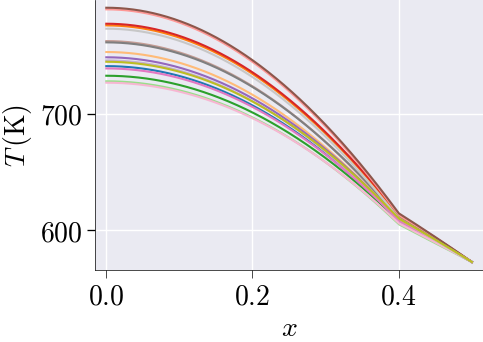

In [ ]:
fig, ax = plt.subplots(figsize=(5,3.5))
plt.rcParams['axes.prop_cycle'] = plt.cycler("color", clr)

for i in range(len(NLS_train_ms)):
    
    # ax.plot(d.xi[0][:-1], NLS_train_ms[i])
    ax.plot(d.xi[0][:-1], NLS_train[i])

plt.ylabel('$T\,$(K)')    
plt.xlabel('$x$')


#### Perform SVD on the snapshots (calculate $\mathbb{V}(=\mathbb{W}$)):

Number of modes selected: 5


Text(0.5, 0, 'POD modes ($k$)')

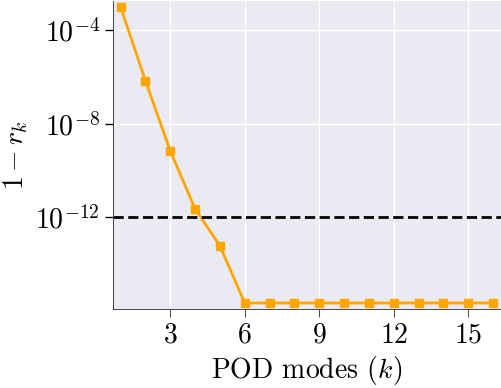

In [15]:
# fig, ax = plt.subplots(figsize=(5,3.5))
plt.rcParams['lines.markersize'] = 6
plt.rcParams['lines.linewidth'] = 2.0

n_sel, U = svd_mode_selector(NLS_train_ms, tolerance=1e-12,modes=True)
V_sel = U[:, :n_sel]

plt.ylabel('$1-r_{k}$')
plt.xlabel('POD modes ($k$)')

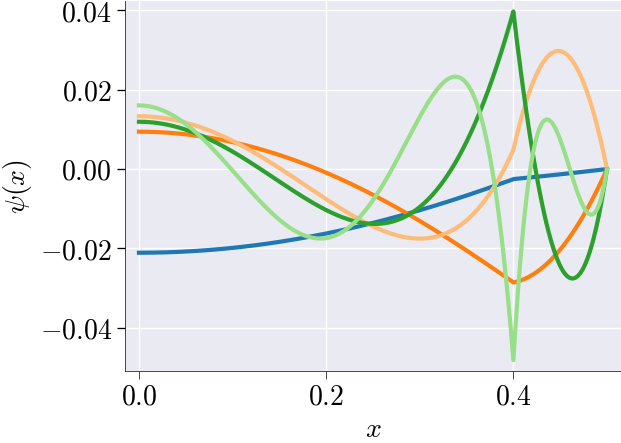

In [ ]:
fig, ax = plt.subplots()
plt.rcParams['axes.prop_cycle'] = plt.cycler("color", clr)

for i in range(n_sel):
    # Plot = plot(d.xi[0][:-1], V_sel[:,i], ax=ax)
    # Plot.line_()
    plt.plot(d.xi[0][:-1], V_sel[:,i],lw=3)

ax.set_xlabel('$x$')
ax.set_ylabel('$\psi(x)$')
    
ax.yaxis.set_major_locator(MaxNLocator(nbins=5)) 
plt.show()


### ROM Simulation

In [17]:
Data_cls.mean = NLS_train_mean

In [18]:
eval_rom = True

In [19]:
if eval_rom:
    
    ROM = ROM_simulation(Data_cls, NLS_test, param_list, test_mask, V_sel)
    ROM.run_simulation()

### Performance Statistics

In [20]:
NLS_rom = np.asarray(ROM.NL_solutions_rom)
ROM_speed_up = ROM.speed_up
ROM_speed_up=ROM_speed_up[1:]
ROM_relative_error = ROM.rom_error

##### Visualize

<Axes: xlabel='Speed-up'>

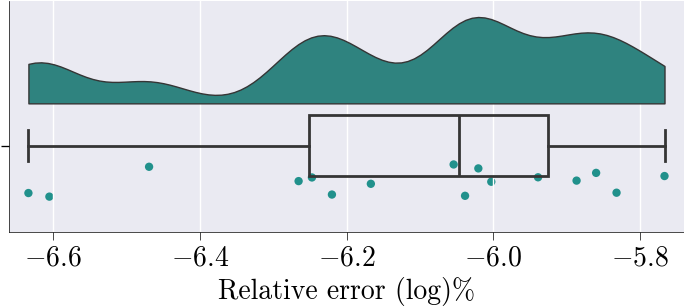

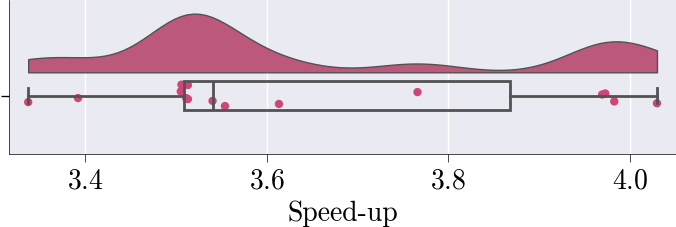

In [21]:
df_B = pd.DataFrame({'':'','Relative error (log)%':np.log10(ROM_relative_error)})

fig, ax = plt.subplots(figsize=(8.7, 3))
pt.RainCloud(x = '', y = 'Relative error (log)%', data = df_B, palette = "viridis", bw = 0.2,
    width_viol = 1., ax = ax, orient = "h",pointplot = False, dodge=False, alpha=1.0, width_box = 0.35, linewidth=1, point_size =6.0, move=0.2)

# ===

df_D = pd.DataFrame({'':'','Speed-up':ROM_speed_up})

fig, ax = plt.subplots(figsize=(8.6, 2))
pt.RainCloud(x = '', y = 'Speed-up', data = df_D, palette = "plasma",
    width_viol = 1.0, ax = ax, orient = "h",pointplot = False, dodge=True, alpha=1.0, width_box = 0.25, linewidth=1, point_size =6.0)